In [1]:
from functools import partial

import plotly.express
import plotly.io as pio

from rhana.pattern import RheedMask, RheedConfig, Rheed
from rhana.spectrum.spectrum import *
from rhana.labeler.unet import *
from rhana.io.kashiwa import *
from rhana.phaser.distance import RHEEDMaskDistancePhaser, DBSCANDistanceCluster

In [2]:
rheed_folder = Path("assets/LastImage")
crop_image_folder = rheed_folder.parent / ( rheed_folder.stem + "_cropped" )

# Load data

## Load rheed and mask from ApplyUNetwithTracking notebook's output csv

In [3]:
df = pd.read_csv(crop_image_folder / "rheed_masks.csv" )

In [4]:
df = df.set_index("crop_path")

In [5]:
df.index = df.index.map(Path)
# extract experiment code
# user might need to modifiy this
ITs = list( map( lambda x: x.stem, df.index ) )
df['IT'] = ITs

In [6]:
df.head()

image_path  \
crop_path                                                              
assets/LastImage_cropped/IT009/IT009.png  assets/LastImage/IT009.png   
assets/LastImage_cropped/IT021/IT021.png  assets/LastImage/IT021.png   
assets/LastImage_cropped/IT020/IT020.png  assets/LastImage/IT020.png   
assets/LastImage_cropped/IT008/IT008.png  assets/LastImage/IT008.png   
assets/LastImage_cropped/IT022/IT022.png  assets/LastImage/IT022.png   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   full_mask_spot  \
crop_path                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
assets/LastImage_cropped/IT009/IT009.png                                       23564 5 24359 15 25157 18 25956 21 26755 23 27553 26 28353 27 29152 29 29952 29 30751 31 31551 32 32350 33 33150 33 33950 34 34750 34 35549 35 36349 35 37148 36 37949 35 38749 35 39548 36 40348 36 41148 36 41950 34 42750 34 43551 33 44351 33 45152 31 45952 31 46753 30 47553 30 48356 26 49156 25 49958 22 50761 18 51564 14 52364 12 53165 11 53965 10 54767 5 55568 2 59563 2 60363 2 116365 1 117164 6 117963 8 118762 11 119562 10 120362 11 121161 12 121962 11 122761 12 123562 11 124362 11 125162 11 125962 11 126763 9 127563 9 128364 7 129165 4 129965 2 425168 1   
assets/LastImage_cropped/IT021/IT021.png  43509 2 44307 4 45106 4 45905 5 46705 5 46725 2 46728 18 47505 4 47525 25 48305 3 48321 31 49105 3 49121 33 49904 3 49920 35 50704 3 50719 37 51503 4 51519 38 52302 5 52319 39 53102 5 53119 40 53176 1 53901 5 53919 40 53975 2 54702 4 54719 41 54775 2 55502 4 55519 41 55575 2 56302 3 56320 41 56375 2 57101 3 57119 42 57175 2 57919 42 57976 1 58719 42 58776 1 59519 42 59576 1 60319 42 60376 1 61118 43 61176 1 61918 43 61976 1 62718 43 62776 1 63517 44 63576 1 64317 44 64376 1 65117 44 65175 2 65916 45 65975 2 66716 45 66775 2 67516 45 67576 1 68316 45 68375 3 69107 55 69175 2 69906 56 70706 ...   
assets/LastImage_cropped/IT020/IT020.png                                                                                                                                        49122 5 49921 8 50720 10 51519 13 52316 17 53115 20 53915 21 54716 21 55515 23 56315 24 57115 24 57915 25 58715 25 59515 25 60314 26 61114 26 61913 27 62713 27 63513 27 64312 28 65112 28 65912 28 66712 28 67512 29 68314 26 69116 24 69918 22 70720 19 71521 17 72323 14 73127 10 73931 3 165926 3 166725 5 167525 6 168324 6 169124 7 169923 8 170723 9 171523 10 172322 11 173121 13 173921 14 174722 13 175522 13 176321 15 177123 12 177923 12 178724 10 179526 6 180328 1   
assets/LastImage_cropped/IT008/IT008.png  25164 3 25960 13 26759 16 27557 20 28356 22 29155 24 29954 26 30753 28 31553 28 32353 28 33152 30 33952 30 34752 30 35552 30 36351 32 37151 32 37951 31 38751 32 39551 32 40351 32 41151 32 41951 32 42751 32 43552 31 44353 30 45154 28 45954 27 46755 26 47556 25 48359 20 49160 16 49963 11

In [7]:
img_shape = (200, 400)

In [8]:
# user might need to extend this 

lastentries = {}

for IT, group in df.groupby("IT"):
    # sort group by rheed captured time
    # since we only have the last one here 
    # it is naturely the last one
    lastentries[IT] = group.iloc[-1]

In [9]:
lastentries.keys()

dict_keys(['IT004', 'IT006', 'IT007', 'IT008', 'IT009', 'IT010', 'IT011', 'IT012', 'IT013', 'IT014', 'IT015', 'IT016', 'IT017', 'IT018', 'IT020', 'IT021', 'IT022', 'IT023', 'IT024', 'IT025', 'IT027', 'IT028', 'IT029', 'IT030'])

## Load experimental config

In [10]:
from rhana.io.kashiwa import kashiwa_config, cali_exp_pixel_real, exp_voltage, hv2wl

In [11]:
configs = {}

# load experimental setup from the handy python file
# user could just use RheedConfig to create it 
for IT in lastentries.keys():
    voltage = exp_voltage[IT]
    pixel_real = cali_exp_pixel_real[IT]
    wave_length = hv2wl(voltage)
    config = dict(kashiwa_config)
    config['pixel_real'] = cali_exp_pixel_real[IT]
    config = RheedConfig(**config)
    configs[IT] = config

# Phase Mapping

## Extract features and periodicity analysis

In [12]:
from importlib import reload
import rhana
import rhana.periodicity

reload(rhana)
reload(rhana.pattern)
reload(rhana.spectrum.spectrum)
reload(rhana.labeler.unet)
reload(rhana.io.kashiwa)
reload(rhana.phaser.distance)
reload(rhana.periodicity)

from rhana.pattern import RheedMask, RheedConfig, Rheed
from rhana.spectrum.spectrum import *
from rhana.labeler.unet import *
from rhana.io.kashiwa import *
from rhana.phaser.distance import RHEEDMaskDistancePhaser, DBSCANDistanceCluster
lastrds = {}

for k, v in lastentries.items():
    rd = Rheed.from_image(v.name, config=configs[k])
    streak_label = rle_decode(v['crop_mask_streak'], img_shape) if not pd.isna(v['crop_mask_streak']) else None
    spot_label = rle_decode(v['crop_mask_spot'], img_shape) if not pd.isna(v['crop_mask_spot']) else None
    
    if streak_label is not None:
        rdm_streak = RheedMask(rd, streak_label)
        rdm_streak.get_regions(with_intensity=False)
        streak_regions = rdm_streak.filter_regions(10)
    else: 
        streak_label = np.zeros(rd.pattern.shape)
        streak_regions = []
    
    if spot_label is not None:
        rdm_spot = RheedMask(rd, spot_label)
        rdm_spot.get_regions(with_intensity=False)
        spot_regions = rdm_spot.filter_regions(10)
    else:
        spot_label = np.zeros(rd.pattern.shape)
        spot_regions = []
    
    # merge both mask since we only care about periodicity here
    rdm = RheedMask(rd, np.logical_or(streak_label, spot_label))
    rdm.regions = streak_regions + spot_regions
    
    rdm.get_regions_collapse()
    rdm.clean_collapse()
    rdm.fit_collapse_peaks(height=0.001, threshold=0.000, prominence=0.001)
    rdm.analyze_peaks_distance_cent(tolerant=0.15, abs_tolerant=7, allow_discontinue=1)
    
    lastrds[k] = rdm

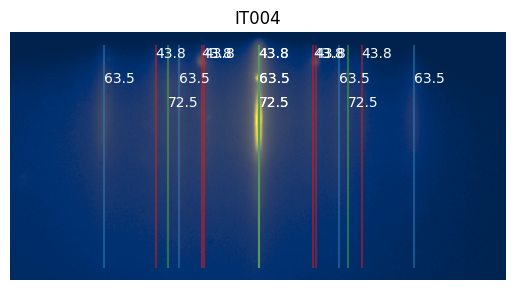

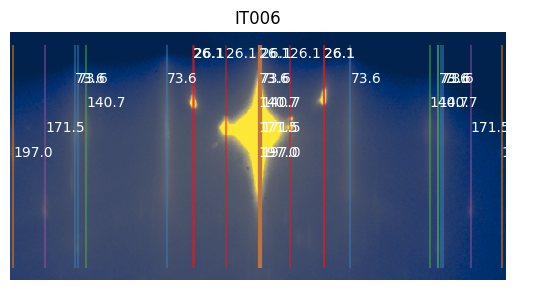

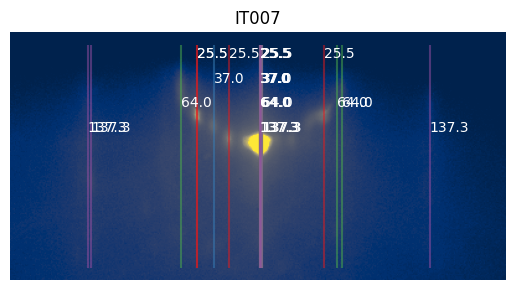

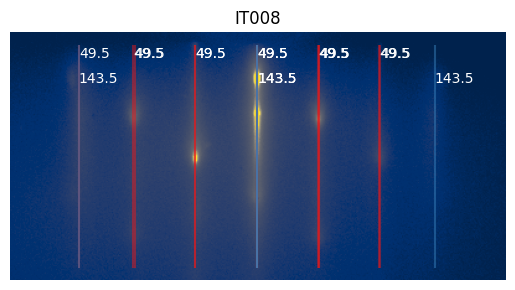

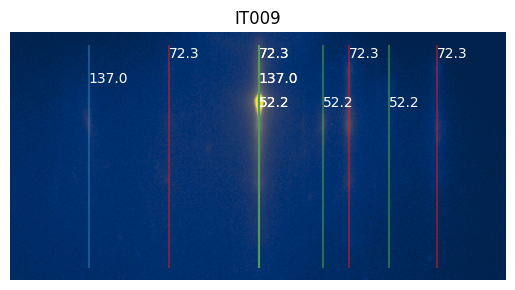

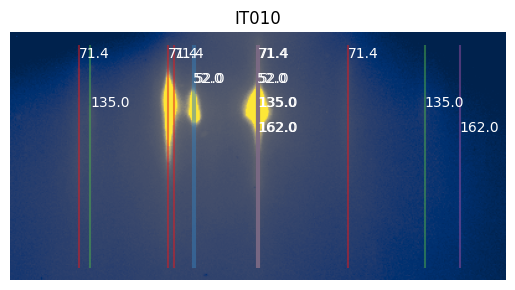

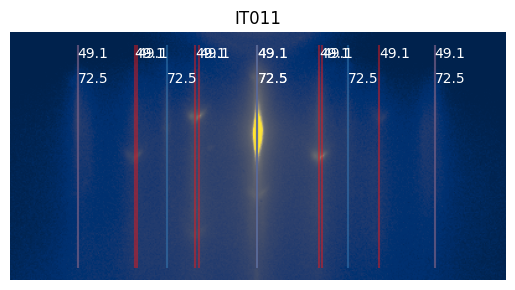

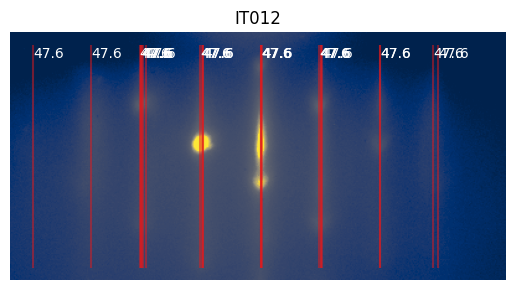

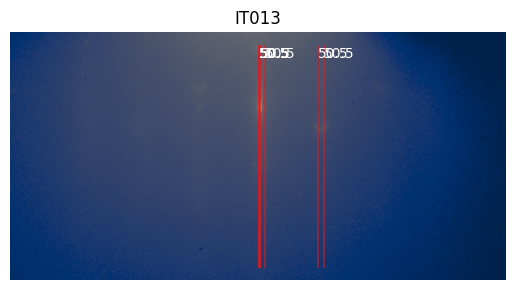

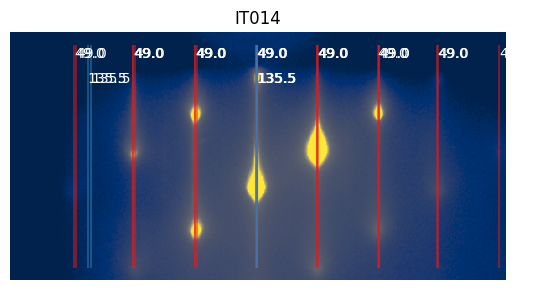

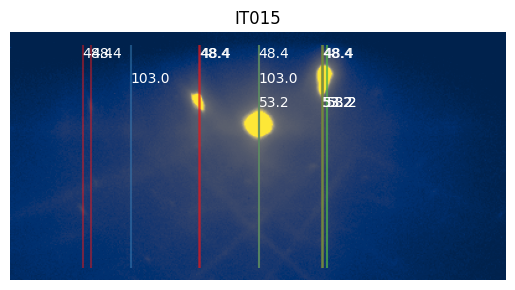

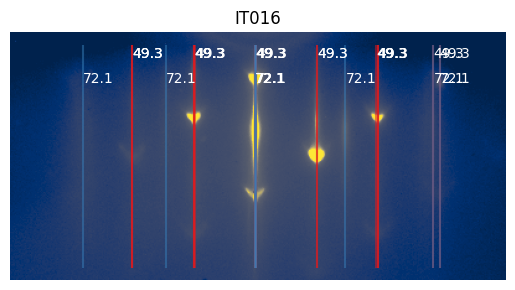

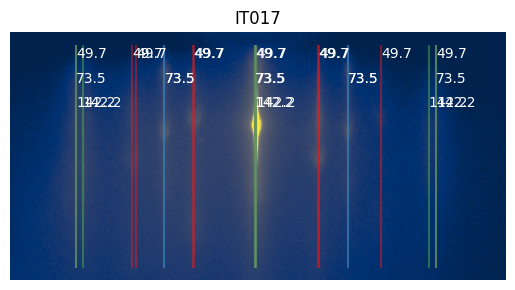

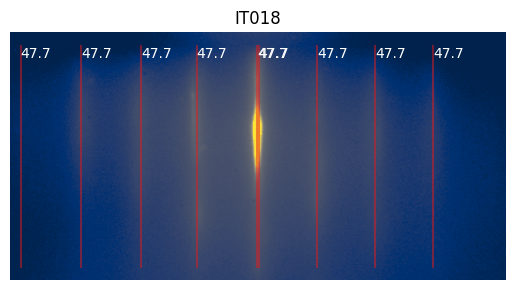

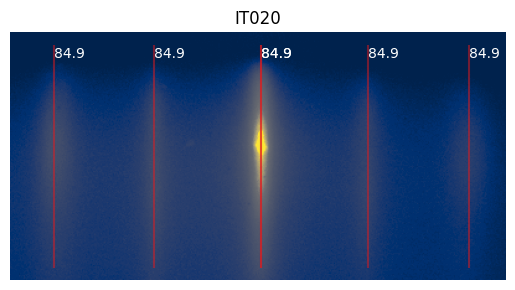

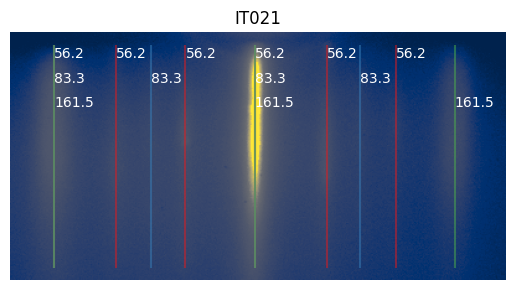

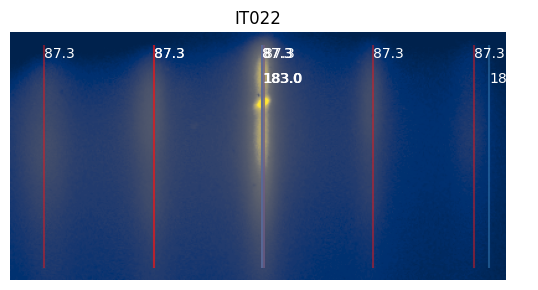

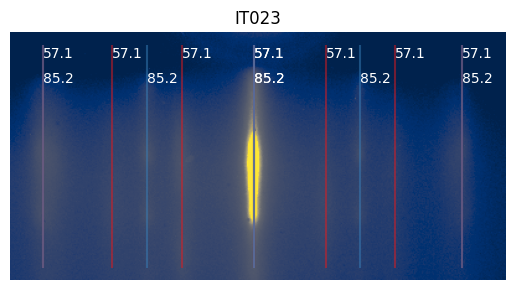

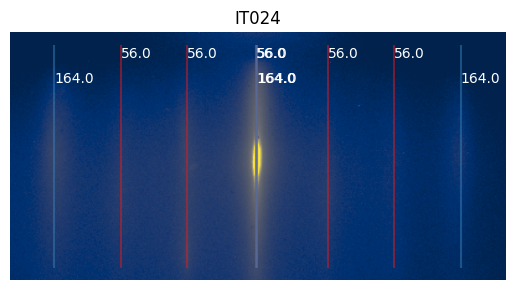

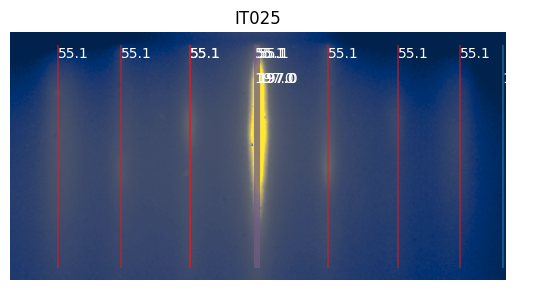

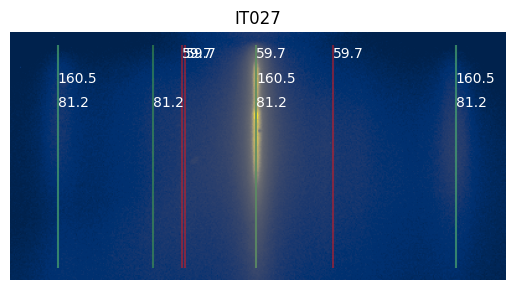

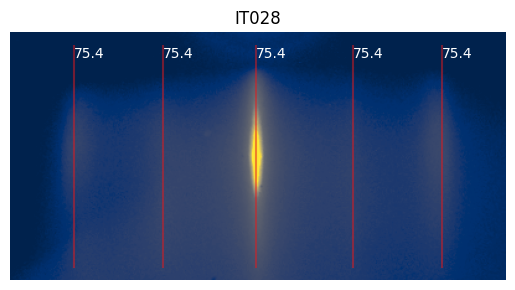

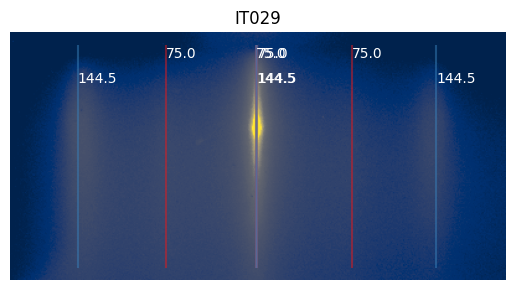

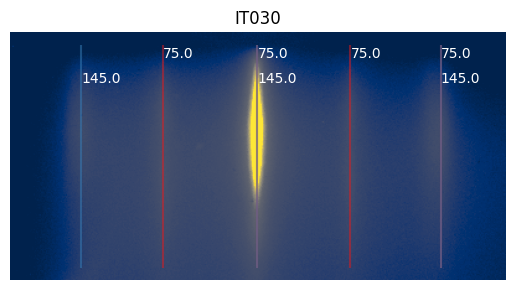

In [13]:
# very cool! right?
for name, rd in lastrds.items():
    rd.plot_peak_dist()
    plt.title(name)
    plt.show()

(None, <Axes: >)

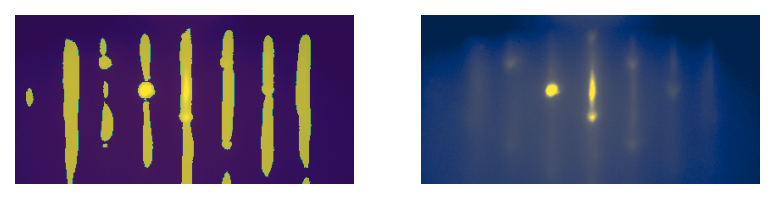

In [14]:
exp_code = 'IT012'
fig, axs = plt.subplots(1, 2, dpi=150)
lastrds[exp_code].plot_pattern_masks(ax=axs[0])
lastrds[exp_code].rd.plot_pattern(ax=axs[1])

## Clustering

In [15]:
# remove bad boy based on sample quality. Not cherry picking 
lastrds.pop("IT015")
lastrds.pop("IT006")

In [16]:
# the convert_dist convert the peak distance from pixel space to G space using the experiment config value
phaser = RHEEDMaskDistancePhaser(list(lastrds.values()), convert_dist=True)

In [17]:
# you can play with eps. The eps work on G now
phaser.run_cluster(eps=1, min_samples=1)

In [18]:
# for debug
# phaser.get_intensity_map()

In [19]:
# check the extracted periodicity from clustering
# if too much or too weird then please go bad and set parameters to a reasonable value
names = list(lastrds.keys())
print("name", "pixel", "G", sep="\t")

for didx, d in phaser.all_peak_dists:
    print(didx)
    name = names[didx[0]]
    rd = lastrds[name]
    #print( name, round(rd.collapses_peaks_flatten_ana_res[didx[1]].avg_dist, 3), round(d, 3), sep="\t" )
    print( name, round(rd.collapses_peaks_flatten_nbr_dist[didx[1]], 3), round(d, 3), sep="\t" )

name	pixel	G
(0, 0)
IT004	-125.0	14.023
(0, 1)
IT004	-83.0	20.312
(0, 2)
IT004	-73.0	23.188
(1, 0)
IT007	-139.0	7.232
(1, 1)
IT007	-136.0	10.493
(1, 2)
IT007	-64.0	18.147
(1, 3)
IT007	-51.0	38.902
(2, 0)
IT008	-144.0	14.037
(2, 1)
IT008	-100.0	40.644
(3, 0)
IT009	-137.0	20.508
(3, 1)
IT009	-72.0	38.808
(3, 2)
IT009	-0.0	14.816
(4, 0)
IT010	-145.0	20.236
(4, 1)
IT010	-136.0	14.745
(4, 2)
IT010	-73.0	38.243
(4, 3)
IT010	-68.0	45.867
(5, 0)
IT011	-145.0	13.927
(5, 1)
IT011	-99.0	20.555
(6, 0)
IT012	-184.0	13.508
(7, 0)
IT013	-0.0	14.32
(8, 0)
IT014	-148.0	13.908
(8, 1)
IT014	-146.0	38.384
(9, 0)
IT016	-140.0	13.98
(9, 1)
IT016	-100.0	20.442
(10, 0)
IT017	-145.0	14.105
(10, 1)
IT017	-140.0	20.838
(10, 2)
IT017	-100.0	40.291
(11, 0)
IT018	-192.0	13.537
(12, 0)
IT020	-167.0	20.362
(13, 0)
IT021	-162.0	13.485
(13, 1)
IT021	-112.0	19.992
(13, 2)
IT021	-84.0	38.71
(14, 0)
IT022	-176.0	20.943
(14, 1)
IT022	-87.0	43.848
(15, 0)
IT023	-170.0	13.704
(15, 1)
IT023	-114.0	20.452
(16, 0)
IT024	-164.0	

## Visualization

In [20]:
from importlib import reload
import rhana
import rhana.periodicity

reload(rhana)
reload(rhana.pattern)
reload(rhana.spectrum.spectrum)
reload(rhana.labeler.unet)
reload(rhana.io.kashiwa)
reload(rhana.phaser.distance)
reload(rhana.periodicity)

from rhana.pattern import RheedMask, RheedConfig, Rheed
from rhana.spectrum.spectrum import *
from rhana.labeler.unet import *
from rhana.io.kashiwa import *
from rhana.phaser.distance import RHEEDMaskDistancePhaser, DBSCANDistanceCluster

phaser = RHEEDMaskDistancePhaser(list(lastrds.values()), convert_dist=True)
phaser.run_cluster()

# load the experiment condition for each rheed sequence
x = [ cali_exp_cons[k][1] for k in lastrds.keys() ] 
y = [ cali_exp_cons[k][0] for k in lastrds.keys() ] 

name = list(lastrds.keys())

# looks similar to the one on the publication
fig = phaser.plot_intensity_map(
    x, y, 
    name=name, 
    xlabel="T (°C)", 
    ylabel="P<sub>O<sub>2</sub></sub> (Torr)", 
    log_x=False, 
    log_y=True, 
    x_space=6,
    y_space=0.5,
    max_num_row=5,
    reverse_x=False,
    reverse_y=False,
    scatter_size=15
)

# you can still change the plot
fig.update_layout(
    height = 600,
    width = 1300,    
    legend = dict(title="Distance (nm<sup>-1</sup>)"),
    xaxis = dict(
        tickmode = 'linear',        
        tick0 = 300,
        dtick = 50,
        ticks="outside",
        # mirror = True,
        showline=True,
        linewidth=1, linecolor='black'        
    ),
    yaxis = dict(
        ticks="outside",
        # mirror = True,       
        showline=True,
        linewidth=1, linecolor='black'        
    )
)

In [ ]:
fig.write_html(rheed_folder/"phase_mapping.html")
fig.write_image(rheed_folder/"phase_mapping.png")

# Plots for the publication
Then by some magic from the elden one, these images were pieced together.

In [80]:
x = [ cali_exp_cons[k][1] for k in lastrds.keys() ] 
y = [ cali_exp_cons[k][0] for k in lastrds.keys() ] 

IT_name = list(lastrds.keys())

In [81]:
pio.templates

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

In [50]:
name = [ f"{pexp}-{temp}" for pexp, temp in zip(-np.log10(y).astype(int), x) ]

In [51]:
IT_notaion_lookup = {n1:n2 for n1, n2 in zip(IT_name, name)}

In [52]:
IT_notaion_lookup["IT017"]

'5-805'

In [53]:
import colorlover

In [54]:
n_labels = len(np.unique(phaser.dc.labels))

all_multihotencoding = np.zeros( (len(phaser.rdms), n_labels ) )
all_percentage = np.zeros( (len(phaser.rdms), n_labels ) )

for i, rdm, in enumerate(phaser.rdms):
    all_multihotencoding[i, rdm.cluster_labels_unique] = 1
    all_percentage[i, rdm.cluster_labels_unique] = rdm.group_percent

In [55]:
all_percentage.shape

(24, 6)

In [56]:
colorlover.scales['11']['qual']

{'Paired': ['rgb(166,206,227)',
  'rgb(31,120,180)',
  'rgb(178,223,138)',
  'rgb(51,160,44)',
  'rgb(251,154,153)',
  'rgb(227,26,28)',
  'rgb(253,191,111)',
  'rgb(255,127,0)',
  'rgb(202,178,214)',
  'rgb(106,61,154)',
  'rgb(255,255,153)'],
 'Set3': ['rgb(141,211,199)',
  'rgb(255,255,179)',
  'rgb(190,186,218)',
  'rgb(251,128,114)',
  'rgb(128,177,211)',
  'rgb(253,180,98)',
  'rgb(179,222,105)',
  'rgb(252,205,229)',
  'rgb(217,217,217)',
  'rgb(188,128,189)',
  'rgb(204,235,197)']}

In [57]:
#"set3"
#"Paired"

folder = Path("publication/pie_phase")
folder.mkdir(exist_ok=True)

for i in range(len(all_percentage)):
    fig = go.Figure()
    fig.add_trace(
        go.Pie(
            labels = phaser.dc.mean_dists,
            values=all_percentage[i],
            hoverinfo='label+percent+name',
            direction ='clockwise',
            sort=False,
            textinfo='none',
            marker_colors=colorlover.scales['11']['qual']['Paired'],
            opacity=1,
            showlegend=False,
        ),
    )
#     fig.show()
    fig.update_layout(go.Layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    ))

    fig.write_image(str(folder/f"{name[i]}.png"))
    fig.write_html(str(folder/f"{name[i]}.html"))

In [47]:
fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels = [f"{d:.2f}" for d in phaser.dc.mean_dists],
        values=all_percentage[i],
        hoverinfo='label+percent+name',
        direction ='clockwise',
        sort=False,
        textinfo='none',
        marker_colors=colorlover.scales['11']['qual']['Paired'],
        opacity=1,
        showlegend=True,
#         visible=False,
    ),
)
#     fig.show()
fig.update_layout(go.Layout(
    legend = dict(title="Distance (nm<sup>-1</sup>)"),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
))

fig.write_image(str(folder/f"legend.svg"))
fig.write_image(str(folder/f"legend.png"), scale=4)
fig.write_html(str(folder/f"legend.html"))

In [58]:
save_folder = Path("publication")

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = np.array(x),
        y = np.array(y) * 3,
        text = np.array(name),
        showlegend = False,
        mode = "text"
    )    
)

fig.add_trace(
    go.Scatter(
        x = np.array(x),
        y = np.array(y),
        showlegend = False,
        mode = "markers"
    )    
)

fig.update_yaxes(title="P<sub>O<sub>2</sub></sub> (Torr)", type='log', exponentformat="power", range=(-6, 0))
fig.update_xaxes(dtick=50, title="T (°C)", range=(350, 1120))

fig.update_layout(
    height=600, width=1000,
    legend = dict(title="Distance (Pixel)"),
    template="plotly_white",
    
    xaxis = dict(
        tickmode = 'linear',        
        tick0 = 300,
        dtick = 50,
        ticks="outside",
#         mirror = True,
        showline=True,
        linewidth=1, linecolor='black'        
    ),
    yaxis = dict(
        ticks="outside",
#         mirror = True,       
        showline=True,
        linewidth=1, linecolor='black'        
    )
)

if False:
    # no xrd overlay since the new XRD is not clear
    for i in range(1, 1+len(xrd_overlay.values())):
        color = plotly.express.colors.qualitative.Dark2[i]
        color = color.replace("rgb", "rgba")
        color = color[:-1] + ", 0.1)"

        fig.add_trace(
            go.Scatter(
                showlegend=False,
                x=xrd_overlay[f'line{i}']['x'],
                y=xrd_overlay[f'line{i}']['y'],
    #             fill='tonexty',
    #             fillcolor=color,
    #             mode="none"
                line={"color":"black", "width":1, "dash":"dash"},
                opacity=0.8,
                mode="lines",
            )) # fill down to xaxis


# , height=581, width=1325
fig.write_image(str(save_folder/f"phasemapping_backbone.svg"))
fig.write_image(str(save_folder/f"phasemapping_backbone.png"), scale=2)
fig.write_html(str(save_folder/f"phasemapping_backbone.html"))

fig
